## Impact of model resolution on MHWs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import scipy.signal as sig

import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [3]:
import dask, dask_jobqueue 
import dask.distributed as dask_distributed

cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_std/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42513 instead
  warnings.warn(


In [4]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          17170762      base dask-wor smomw379  R       2:28      1 nesh-clk424
          17170666      base dask-wor smomw379  R      11:13      1 nesh-srp238


In [5]:
client

<Client: 'tcp://172.18.4.22:37377' processes=4 threads=32, memory=74.52 GiB>

## load files

In [6]:
## load mask: host
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'atlantic_mask_3D.nc').squeeze()
land_maskO = mask.tmask.isel(X=range(750,1250)).rename({'X':'x','Y':'y','z':'deptht'})

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS006-P-V/nemo/suppl/mesh_mask.nc'
dsMO = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).rename({'z':'deptht'})

## only atlantic and mask land values based on native ORCA025 grid
maskO = (land_maskO*dsMO.tmask)
maskO[:,852:,:] = 0 ## remove atlantic points outside nest domain
maskO[:,0:353,:] = 0 

A = (dsMO.e1t * dsMO.e2t).where(maskO == 1).compute()

In [7]:
## load mask OISST
ds_ATL_OISST = xr.open_dataset('/gxfs_work/geomar/smomw379/DATA/OBS/NOAA_OISST/NOAA_OISST_ATLmask.nc')
mask_OISST = ds_ATL_OISST.mask_atl.rename({'lon':'x','lat':'y'})

In [8]:
def load_stats(EXP, baseline, var):
    path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/MHW_Detection/ANALYSIS/'
    ds_00 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-00.nc')
    return ds_00

In [9]:
## VIKING20X
# cycle 6
dsB6_D_00_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'MHW-days')
dsB6_R_00_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'Duration')
dsB6_E_00_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'Events')
dsB6_M_00_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'IntensityMax')

In [10]:
## NOAA OISST
path = '/gxfs_work/geomar/smomw379/DATA/OBS/NOAA_OISST/MHW/MHW_Detection/ANALYSIS/'

dsOISST_D = xr.open_dataset(path+'NOAA_OISST_1y_19800101_20231231_MHW-days-WMO.nc').sel(time=slice('1982','2022'))
dsOISST_E = xr.open_dataset(path+'NOAA_OISST_1y_19800101_20231231_Events-WMO.nc').sel(time=slice('1982','2022'))
dsOISST_R = xr.open_dataset(path+'NOAA_OISST_1y_19800101_20231231_Duration-WMO.nc').sel(time=slice('1982','2022'))
dsOISST_M = xr.open_dataset(path+'NOAA_OISST_1y_19800101_20231231_IntensityMax-WMO.nc').sel(time=slice('1982','2022'))

lon_OISSTo = dsOISST_D.x.values
lat_OISST = dsOISST_D.y.values

In [11]:
A_OISST = (0.25 * 110.574) * (0.25*111.320*np.cos(np.deg2rad(lat_OISST)))
A_OISST_2D = xr.DataArray(np.repeat(A_OISST, len(lon_OISSTo)).reshape((len(lat_OISST), len(lon_OISSTo)))).rename({'dim_0':'y', 'dim_1':'x'})
A_OI = A_OISST_2D.where(mask_OISST==1).compute()

In [12]:
## define time axis
time = np.arange(1980,2023)

## Area averages

In [13]:
def area_average(dsD, dsL, dsI, dsE, A):
    ## area average: weigh by grid cell area so that subpolar latitudes have no larger contribution as there are more, but smaller grid points
    ## ignore grid points where no heatwaves occured for event based averages (duration, intensity)
    ## don't ignore them for grid point based averages (MHW days per year and Events per year)
    Area_averageD =  (dsD.N_MHW_days * A).sum(('x','y')) / A.sum(('x','y'))
    Area_averageL =  (dsL.where(dsL>0).Duration_mn * A).sum(('x','y')) / A.where(dsL.Duration_mn>0).sum(('x','y'))
    Area_averageI =  (dsI.where(dsI>0).Intensity_max_mn * A).sum(('x','y')) / A.where(dsI.Intensity_max_mn>0).sum(('x','y'))
    Area_averageE =  (dsE.N_events * A).sum(('x','y')) / A.sum(('x','y'))

    return Area_averageD, Area_averageL, Area_averageI, Area_averageE

In [14]:
## surface
MHW_domain_B6_00_WMO, DUR_domain_B6_00_WMO, INT_domain_B6_00_WMO, EVT_domain_B6_00_WMO = area_average(dsB6_D_00_WMO, dsB6_R_00_WMO, dsB6_M_00_WMO, dsB6_E_00_WMO, A.isel(deptht=0))
MHW_domain_OI_00_WMO, DUR_domain_OI_00_WMO, INT_domain_OI_00_WMO, EVT_domain_OI_00_WMO = area_average(dsOISST_D, dsOISST_R, dsOISST_M, dsOISST_E, A_OI)


In [15]:
## surface - northern hemisphere
MHW_NH_B6_00_WMO, DUR_NH_B6_00_WMO, INT_NH_B6_00_WMO, EVT_NH_B6_00_WMO = area_average(dsB6_D_00_WMO.isel(y=slice(559,None)), dsB6_R_00_WMO.isel(y=slice(559,None)),
                                                                                      dsB6_M_00_WMO.isel(y=slice(559,None)), dsB6_E_00_WMO.isel(y=slice(559,None)),
                                                                                      A.isel(deptht=0, y=slice(559,None)))

MHW_SH_B6_00_WMO, DUR_SH_B6_00_WMO, INT_SH_B6_00_WMO, EVT_SH_B6_00_WMO = area_average(dsB6_D_00_WMO.isel(y=slice(0,437)), dsB6_R_00_WMO.isel(y=slice(0,437)),
                                                                                      dsB6_M_00_WMO.isel(y=slice(0,437)), dsB6_E_00_WMO.isel(y=slice(0,437)),
                                                                                      A.isel(deptht=0, y=slice(0,437)))


MHW_NH_OI_00_WMO, DUR_NH_OI_00_WMO, INT_NH_OI_00_WMO, EVT_NH_OI_00_WMO = area_average(dsOISST_D.isel(y=slice(420,None)), dsOISST_R.isel(y=slice(420,None)), 
                                                                                      dsOISST_M.isel(y=slice(420,None)), dsOISST_E.isel(y=slice(420,None)), A_OI.isel(y=slice(420,None)))

MHW_SH_OI_00_WMO, DUR_SH_OI_00_WMO, INT_SH_OI_00_WMO, EVT_SH_OI_00_WMO = area_average(dsOISST_D.isel(y=slice(0,299)), dsOISST_R.isel(y=slice(0,299)), 
                                                                                      dsOISST_M.isel(y=slice(0,299)), dsOISST_E.isel(y=slice(0,299)), A_OI.isel(y=slice(0,299)))


## Maps

In [16]:
lonO=dsB6_D_00_WMO.nav_lon
latO=dsB6_D_00_WMO.nav_lat

In [17]:
##
DUR_B6_00_map = np.ma.masked_equal(dsB6_R_00_WMO.Duration_mn.mean('time') *  maskO.isel(deptht=0),0)
EVT_B6_00_map = np.ma.masked_equal(dsB6_E_00_WMO.N_events.mean('time')  *  maskO.isel(deptht=0),0)
INT_B6_00_map = np.ma.masked_equal(dsB6_M_00_WMO.Intensity_max_mn.where(dsB6_M_00_WMO.Intensity_max_mn!=0).mean('time') *  maskO.isel(deptht=0),0)

##
DUR_OI_00_map = np.ma.masked_equal(dsOISST_R.Duration_mn.mean('time') *  mask_OISST,0)
EVT_OI_00_map = np.ma.masked_equal(dsOISST_E.N_events.mean('time') *  mask_OISST,0)
INT_OI_00_map = np.ma.masked_equal(dsOISST_M.Intensity_max_mn.where(dsOISST_M.Intensity_max_mn!=0).mean('time') *  mask_OISST,0)

## plotting

In [18]:
coastline = cft.GSHHSFeature(scale='intermediate')

def plot_cartopy(ax, xticks, yticks, ylabels=True, xlabels=True, continents=True):
    '''Add cartopy features to the map'''

    ax.set_extent([-99,20,-22,59])

    if continents:
       ax.add_feature(coastline, edgecolor='darkgrey', facecolor='darkgrey', zorder=100)

    ## add labels
    ax.set_xticks(xticks, crs = ccrs.PlateCarree())
    ax.set_yticks(yticks, crs = ccrs.PlateCarree())
    if xlabels:
      lon_formatter = LongitudeFormatter()
      ax.xaxis.set_major_formatter(lon_formatter)
    else: 
       ax.set_xticklabels([])
    if ylabels:
      lat_formatter = LatitudeFormatter()
      ax.yaxis.set_major_formatter(lat_formatter)
    else: 
       ax.set_yticklabels([])

In [19]:
def find_i_j(lon, lat, LON, LAT):
    '''  get indices of (lon, lat) point on NEMO grid (LON,LAT)
         lon, lat: Point to get the indice
         LON, LAT: NEMO nav_lon, nav_lat '''
    a = abs(LAT - lat) + abs(LON - lon)
    j, i = np.unravel_index(a.argmin(), a.shape)
    return j, i

In [20]:
## section end points on model grid
jj,ii = find_i_j(-45,65,lonO,latO)
j0,i0 = find_i_j(-45,55,lonO,latO)
j1,i1 = find_i_j(-70,55,lonO,latO)
j2,i2 = find_i_j(-70,19,lonO,latO)
j3,i3 = find_i_j(0,19,lonO,latO)
j4,i4 = find_i_j(0,-34,lonO,latO)

## define section segments
y_sec = np.arange(j1,jj); x_sec = i0
y_sec0 = j1; x_sec0 = np.arange(i2,i0)
y_sec1 = np.arange(j2,j1); x_sec1 = i2
y_sec2 = j2; x_sec2 = np.arange(i2,i3)
y_sec3 = np.arange(j4,j3); x_sec3 = i3

def plot_section(ax):
    ax.plot(lonO[y_sec,x_sec], latO[y_sec,x_sec], color='k', zorder=100)
    ax.plot(lonO[y_sec0,x_sec0], latO[y_sec0,x_sec0], color='k', zorder=100)
    ax.plot(lonO[y_sec1,x_sec1], latO[y_sec1,x_sec1], color='k', zorder=100)
    ax.plot(lonO[y_sec2,x_sec2], latO[y_sec2,x_sec2], color='k', zorder=100)
    ax.plot(lonO[y_sec3,x_sec3], latO[y_sec3,x_sec3], color='k', zorder=100)    

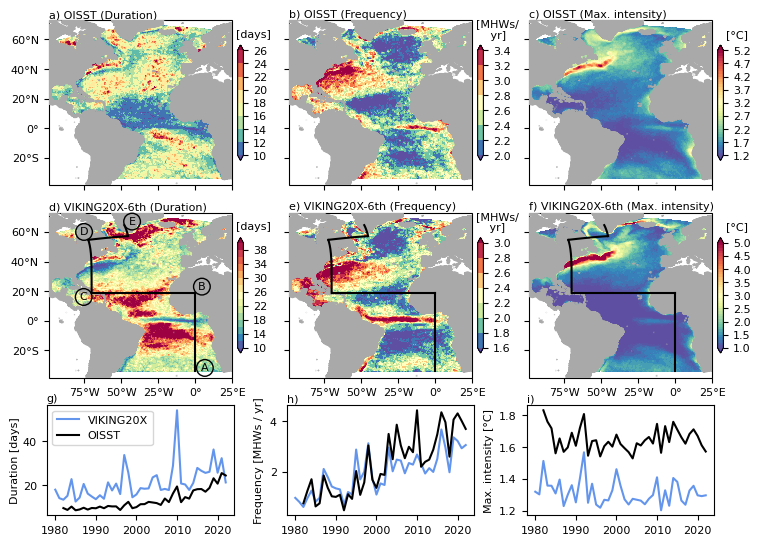

In [22]:
fig = plt.figure(figsize=(7.5,5.5))

ax1 = fig.add_axes([0.0,0.66,0.37,0.3], projection=ccrs.PlateCarree())
ax2 = fig.add_axes([0.32,0.66,0.37,0.3], projection=ccrs.PlateCarree())
ax3 = fig.add_axes([0.64,0.66,0.37,0.3], projection=ccrs.PlateCarree())

ax4 = fig.add_axes([0.0,0.31,0.37,0.3], projection=ccrs.PlateCarree())
ax5 = fig.add_axes([0.32,0.31,0.37,0.3], projection=ccrs.PlateCarree())
ax6 = fig.add_axes([0.64,0.31,0.37,0.3], projection=ccrs.PlateCarree())

ax7 = fig.add_axes([0.06,0.06,0.25,0.2])
ax8 = fig.add_axes([0.38,0.06,0.25,0.2])
ax9 = fig.add_axes([0.7,0.06,0.25,0.2])

##
DUR = ax1.contourf(lon_OISSTo, lat_OISST, DUR_OI_00_map, levels=np.arange(10,28,2), extend='both', cmap='Spectral_r')
plot_cartopy(ax1, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False)
ax1.set_title('a) OISST (Duration)', fontsize=8, loc='left', pad=2)

##
EVT = ax2.contourf(lon_OISSTo, lat_OISST, EVT_OI_00_map, levels=np.arange(2,3.6,0.2), extend='both', cmap='Spectral_r')
plot_cartopy(ax2, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False, ylabels=False)
ax2.set_title('b) OISST (Frequency)', fontsize=8, loc='left', pad=2)

##
INT = ax3.contourf(lon_OISSTo, lat_OISST, INT_OI_00_map, levels=np.arange(1.2,5.3,0.1), extend='both', cmap='Spectral_r')
plot_cartopy(ax3, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False, ylabels=False)
ax3.set_title('c) OISST (Max. intensity)', fontsize=8, loc='left', pad=2)

##
DUR1 = ax4.contourf(lonO, latO, DUR_B6_00_map, levels=np.arange(10,42,2), extend='both', cmap='Spectral_r')
plot_cartopy(ax4, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20))
ax4.set_title('d) VIKING20X-6th (Duration)', fontsize=8, loc='left', pad=2)
plot_section(ax4)

##
EVT1 = ax5.contourf(lonO, latO, EVT_B6_00_map, levels=np.arange(1.6,3.2,0.2), extend='both', cmap='Spectral_r')
plot_cartopy(ax5, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), ylabels=False)
ax5.set_title('e) VIKING20X-6th (Frequency)', fontsize=8, loc='left', pad=2)
plot_section(ax5)

##
INT1 = ax6.contourf(lonO, latO, INT_B6_00_map, levels=np.arange(1.,5.1,0.1), extend='both', cmap='Spectral_r')
plot_cartopy(ax6, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), ylabels=False)
ax6.set_title('f) VIKING20X-6th (Max. intensity)', fontsize=8, loc='left', pad=2)
plot_section(ax6)

# colorbars
cb = plt.colorbar(DUR, ax=[ax1], orientation='vertical', shrink=0.7, pad=0.02)
cb.set_label('[days]', y=1.2, labelpad=-10, rotation=0, fontsize=8)
cb = plt.colorbar(EVT, ax=[ax2], orientation='vertical', shrink=0.7, pad=0.02)
cb.set_label('[MHWs/\n yr]', y=1.3, labelpad=-10, rotation=0, fontsize=8)
cb = plt.colorbar(INT, ax=[ax3], orientation='vertical', shrink=0.7, pad=0.02)
cb.set_label('[°C]', y=1.2, labelpad=-10, rotation=0, fontsize=8)
cb = plt.colorbar(DUR1, ax=[ax4], orientation='vertical', shrink=0.7, pad=0.02)
cb.set_label('[days]', y=1.2, labelpad=-10, rotation=0, fontsize=8)
cb = plt.colorbar(EVT1, ax=[ax5], orientation='vertical', shrink=0.7, pad=0.02)
cb.set_label('[MHWs/\n yr] ', y=1.3, labelpad=-10, rotation=0, fontsize=8)
cb = plt.colorbar(INT1, ax=[ax6], orientation='vertical', shrink=0.7, pad=0.02)
cb.set_label('[°C]', y=1.2, labelpad=-10, rotation=0, fontsize=8)

##### Timeseries
##
ax7.plot(time, DUR_domain_B6_00_WMO, color='cornflowerblue', label='VIKING20X')
ax7.plot(time[2:], DUR_domain_OI_00_WMO, color='k', label='OISST')
ax7.legend(fontsize=8)
ax7.set_ylabel('Duration [days]', fontsize=8, labelpad=2)
ax7.set_title('g)', loc='left', fontsize=8, pad=2.5)

##
ax8.plot(time, EVT_domain_B6_00_WMO, color='cornflowerblue')
ax8.plot(time[2:], EVT_domain_OI_00_WMO, color='k')
ax8.set_ylabel('Frequency [MHWs / yr]', fontsize=8)
ax8.set_title('h)', loc='left', fontsize=8, pad=2.5)

##
ax9.plot(time, INT_domain_B6_00_WMO, color='cornflowerblue')
ax9.plot(time[2:], INT_domain_OI_00_WMO, color='k')
ax9.set_ylabel('Max. intensity [°C]', fontsize=8)
ax9.set_title('i)', loc='left', fontsize=8, pad=2.5)


ax4.text(-45,65,'E', zorder=100, fontsize=8, bbox=dict(boxstyle='circle', facecolor='none', edgecolor='k')) 
ax4.text(-78,58,'D', zorder=100, fontsize=8, bbox=dict(boxstyle='circle', facecolor='none', edgecolor='k')) 
ax4.text(-78,14,'C', zorder=100, fontsize=8, bbox=dict(boxstyle='circle', facecolor='none', edgecolor='k')) 
ax4.text(2,21,'B', zorder=100, fontsize=8, bbox=dict(boxstyle='circle', facecolor='none', edgecolor='k')) 
ax4.text(4,-34,'A', zorder=100, fontsize=8, bbox=dict(boxstyle='circle', facecolor='none', edgecolor='k')) 

plt.savefig('Surface_Validation.png', dpi=300)

In [22]:
print(np.corrcoef(DUR_domain_B6_00_WMO[2:],DUR_domain_OI_00_WMO)[0,1])
print(np.corrcoef(EVT_domain_B6_00_WMO[2:],EVT_domain_OI_00_WMO)[0,1])
print(np.corrcoef(INT_domain_B6_00_WMO[2:],INT_domain_OI_00_WMO)[0,1])

0.6572000227230006
0.9070673139234584
0.7888626586497408


In [23]:
print(np.corrcoef(sig.detrend(DUR_domain_B6_00_WMO[2:]),sig.detrend(DUR_domain_OI_00_WMO))[0,1])
print(np.corrcoef(sig.detrend(EVT_domain_B6_00_WMO[2:]),sig.detrend(EVT_domain_OI_00_WMO))[0,1])
print(np.corrcoef(sig.detrend(INT_domain_B6_00_WMO[2:]),sig.detrend(INT_domain_OI_00_WMO))[0,1])

0.4647684139524867
0.7659557413720764
0.7985106495211053


## Save data for publication
* full output (annual mean MHW characteristics) already stored 